<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Umap_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trimap

     |████████████████████████████████| 5.6MB 3.5MB/s 
     |████████████████████████████████| 645kB 51.3MB/s 
  Created wheel for trimap: filename=trimap-1.0.14-cp36-none-any.whl size=14635 sha256=e2d85ff9eb8f1ddd606f52e5777e1fb444de5d444f88df314e276013095702a7
  Stored in directory: /root/.cache/pip/wheels/85/9c/37/60a2bdc96dfd67939ba22d506abaf6a84437bd76a86741cbd6
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297324 sha256=43ad75ce4cad58d8c0579dd7d74df9b716e82f016efb7e19576c9c2c8fda8140
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built trimap annoy


In [2]:
!pip install hdbscan

     |████████████████████████████████| 4.7MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2305960 sha256=bd1326e35b06dd22fc6bd707fc7c22665f228b01eb576dc44a9aa6b4783bc2b2
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan


In [3]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import pathlib
import os
import shutil
import fnmatch

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!rm -rf /content/newtDatasetLite

In [ ]:
!rm -rf /content/content/newtDataset

In [ ]:
!unzip -q '/content/drive/My Drive/Stage/lite_ds/newtDataset.zip'

replace content/newtDataset/test/KM00264/Bascha_P01_T03_K13_M_Adult_868_2019053018072339.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!unzip -q '/content/drive/My Drive/Stage/lite_ds/newtDatasetLite.zip'

In [5]:
!unzip -q '/content/drive/My Drive/Stage/lite_ds/self_supervised_dataset.zip'

In [15]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=800, weight_adj=5000, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 1797 points with dimension 64
pre-processing
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 290.681, Violated triplets: 0.2941
Iteration:  200, Loss: 282.334, Violated triplets: 0.2857
Iteration:  300, Loss: 275.666, Violated triplets: 0.2789
Iteration:  400, Loss: 270.400, Violated triplets: 0.2736
Iteration:  500, Loss: 267.213, Violated triplets: 0.2704
Iteration:  600, Loss: 264.521, Violated triplets: 0.2676
Iteration:  700, Loss: 262.098, Violated triplets: 0.2652
Iteration:  800, Loss: 260.532, Violated triplets: 0.2636
Elapsed time: 0:00:02.894698
(1797, 2)


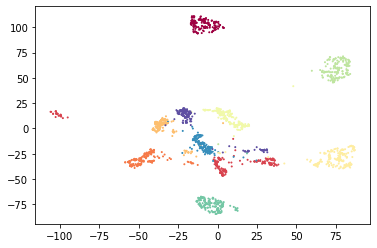

In [ ]:
import trimap
from sklearn.datasets import load_digits

digits = load_digits()

embedding = trimap.TRIMAP(n_iters=800,weight_adj = 5000).fit_transform(digits.data)
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target.astype(int), s=1, cmap='Spectral');
print(embedding.shape)

In [ ]:
labels = hdbscan.HDBSCAN(min_samples=30, min_cluster_size=75).fit_predict(embedding)


In [ ]:
adjusted_rand_score(digits.target, labels), adjusted_mutual_info_score(digits.target, labels)

(0.8282710039632161, 0.8758192958743892)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
gs = trimap.TRIMAP(verbose=False).global_score(digits.data, embedding)
print("global score %2.2f" % gs)

global score 0.91


In [ ]:
mnist = fetch_openml('mnist_784')
mnist.target = mnist.target.astype(int)
print(mnist.target.shape)

(70000,)


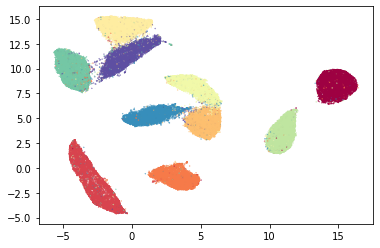

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(mnist.data)

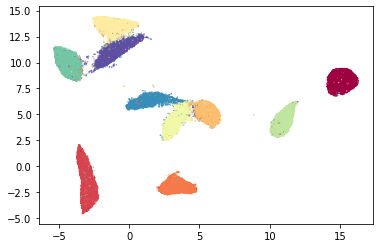

In [ ]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=mnist.target, s=0.1, cmap='Spectral');

In [ ]:
shutil.rmtree('/content/finalDataset') 
shutil.rmtree('/content/newtDataset') 

In [ ]:
train_path = '/content/finalDataset'

In [ ]:
train_path = '/content/finalDataset'
dest_path = '/content/newtDataset/train'
os.mkdir('newtDataset')
os.mkdir('newtDataset/train')

dest1 =  pathlib.Path('newtDataset/train')
source1 = pathlib.Path(train_path)

#os.mkdir('finalDataset/train')

for label in os.listdir(train_path):
  os.mkdir('newtDataset/train' + '/' +  str(label))




for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=nbr_img, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


In [ ]:
shutil.rmtree('/content/finalDataset')

In [ ]:
""" Train/Test split """

train_path = '/content/newtDataset/train'
test_path = '/content/newtDataset/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)
os.mkdir('newtDataset/test')

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..


for label in os.listdir(train_path):
  os.mkdir('newtDataset/test' + '/' +  str(label))

for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=100, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

In [ ]:
!zip -r /content/newtDataset /content/newtDataset

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590794.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590790.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_20190522155907137.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590752.jpg (deflated 10%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590733.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_20190522155907157.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590789.jpg (deflated 9%)
  adding: content/newtDataset/train/KM00497/Bascha_P01_T02_K12_F_Adult_538_2019052215590779.jpg (deflated 9%)
  adding: content/newtDataset/train/KM0

In [ ]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/newtDataset/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/newtDataset/test'))
print(test_size)

55617
55700


In [6]:


#width = 56
#height = 56

train_path = '/content/newtDatasetLite/train'
train_path = '/content/finalDataset'
#test_path = '/content/newtDatasetLite/val'

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-2])
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  #img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  try:
    img = decode_img(img)
    #print(np.max(img))
    print("decoded")
    counter +=1
  except:
    print("erreur décodage")

  return img, label

def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.rgb_to_grayscale(image)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (input_shape[0], input_shape[1]))
  return image, label

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_path = '/content/ds_final/train'
#test_path = '/content/ds_final/test'

train_size = sum(len(files) for _, _, files in os.walk(train_path))
print(train_size)
#test_size = sum(len(files) for _, _, files in os.walk(test_path))
#print(test_size)


input_shape = (75,30,1)



data_dir = pathlib.Path(train_path)
#test_dir = pathlib.Path(test_path)

list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')
#list_ds_test = tf.data.Dataset.list_files(str(test_dir)+'/*/*')

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

print(CLASS_NAMES)


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  #image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)



train_dataset = labeled_ds.map(format_image, num_parallel_calls=AUTOTUNE)

#test_dataset = labeled_ds_test.map(format_image, num_parallel_calls=AUTOTUNE)

count_label = len(os.listdir(train_path))
#print(count_label)

x_train = np.zeros((train_size,input_shape[0],input_shape[1],input_shape[2]))
y_train = np.zeros((train_size))
#x_test = np.zeros((test_size,input_shape[0],input_shape[1],input_shape[2]))
#y_test = np.zeros((test_size))

k=0
for image, label in train_dataset:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1
#k=0
#for image, label in test_dataset:
 # x_test[k,:,:,:] = image
 # y_test[k] = np.where(label)[0][0]
 # k += 1
  #print(np.where(label)[0])

#tfds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#tfds_train = tfds_train.batch(32)
#for i,j in tfds_train:
 # print(i)
  #print(j)
#tfds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#tfds_test = tfds_test.batch(32)
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
#print(y_train)

print("number of individual classes : "+ str(count_label))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
#input_shape = [width,height,3]




20000
['KM00751' 'KM00429' 'KM00045' 'KM00055' 'KM00326' 'KM00807' 'KM00934'
 'KM00672' 'KM00556' 'KM00898']
Tensor("strided_slice:0", shape=(), dtype=string)
decoded
erreur décodage
number of individual classes : 10


In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3]))  # adapt this if using `channels_first` image data format
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))  # adapt this if using `channels_first` image data format


In [ ]:
#x_lite = np.zeros(200*30,75,30,3)
#y_lite = np.zeros(200*30)
x_train_lite = []
y_train_lite = []
x_test_lite = []
y_test_lite = []

for i in range(10):
  for idx,row in enumerate(x_test):
    if y_test[idx]==i:
      x_test_lite.append(row)
      y_test_lite.append(y_test[idx])
  
  for idx,row in enumerate(x_train):
    if y_train[idx]==i:
      x_train_lite.append(row)
      y_train_lite.append(y_test[idx])

x_train_lite = np.array(x_train_lite)
y_train_lite = np.array(y_train_lite)
x_test_lite = np.array(x_test_lite)
y_test_lite = np.array(y_test_lite)

In [ ]:
print(y_lite)

[ 0.  0.  0. ... 29. 29. 29.]


In [ ]:
import gc
gc.collect()

37150

In [ ]:
x_test = 0
y_test = 0
x_train = 0
y_train = 0
dataset = 0
dataset_test = 0

In [ ]:
nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]


In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras import regularizers
#x_train = x_train_lite
#x_test = x_test_lite

def autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')
    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
    h = Dense(dims[0], name='decoder_0')(h)

    return Model(inputs=x, outputs=h)

shape = [x_train.shape[-1], 2000, 2000, 4000, 2048]
autoencoder = autoencoder(shape)

hidden = autoencoder.get_layer(name='encoder_%d' % (len(shape) - 2)).output
encoder = Model(inputs=autoencoder.input, outputs=hidden)

In [10]:
autoencoder.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005))
autoencoder.fit(
            x_train,
            x_train,
            batch_size=100,
            epochs=600,
            #validation_data=(x_test, x_test),
            verbose=1)

Epoch 1/600
200/200 [==============================] - 3s 17ms/step - loss: 0.1220
Epoch 2/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0658
Epoch 3/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0516
Epoch 4/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0437
Epoch 5/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0383
Epoch 6/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0345
Epoch 7/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0316
Epoch 8/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0292
Epoch 9/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0271
Epoch 10/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0255
Epoch 11/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0241
Epoch 12/600
200/200 [==============================] - 3s 17ms/step - loss: 0.0227
E

In [43]:
from tensorflow.keras.models import load_model, save_model

In [45]:
autoencoder.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [47]:
!zip /content/saved_model /content/saved_model

  adding: content/saved_model/ (stored 0%)


In [11]:
embedding = encoder.predict(x_train)

In [ ]:
np.savetxt("embeddings_10_classes.csv", embedding, delimiter=",")

In [ ]:
import pandas
df = pandas.read_csv('/content/embeddings_10_classes.csv')
print(df.head())
print(np.max(df))
print(np.min(df))

   1.449681073427200317e-01  ...  1.900814622640609741e-01
0                 -0.668176  ...                 -0.025711
1                  0.413395  ...                  0.552755
2                  0.230111  ...                  0.003054
3                 -0.011386  ...                  0.011321
4                  0.285850  ...                 -0.047128

[5 rows x 1024 columns]
1.449681073427200317e-01     3.040525
7.474336624145507812e-01     3.199394
7.073513269424438477e-01     2.007434
1.825783699750900269e-01     2.681592
2.218707561492919922e+00     5.040382
                               ...   
2.705654203891754150e-01     2.411876
1.815611869096755981e-01     2.188121
2.477978169918060303e-01     2.165525
-2.344777733087539673e-01    1.954029
1.900814622640609741e-01     2.362087
Length: 1024, dtype: float64
1.449681073427200317e-01    -2.523535
7.474336624145507812e-01    -2.860569
7.073513269424438477e-01    -2.010085
1.825783699750900269e-01    -2.427811
2.218707561492919922e+

In [ ]:
import io
import tensorflow_datasets as tfds

results = encoder.predict(x_test)
results = pca_embedding_test
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for labels in y_test:
    out_m.write(str(labels) + "\n")
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
embedding = encoder.predict(x_train)
comps = 128
print('doing PCA with %s components'%comps, end=' ')
from sklearn.decomposition import PCA
pca = PCA(n_components=comps, whiten=True)
pca_embedding = pca.fit_transform(embedding)

from sklearn.preprocessing import StandardScaler
embedding = StandardScaler().fit_transform(pca_embedding)

#embedding_test = encoder.predict(x_test)
#pca_embedding_test = pca.fit_transform(embedding_test)

doing PCA with 128 components 

In [ ]:
import trimap


trimap_embedding = trimap.TRIMAP(n_iters=500,weight_adj = 500, n_dims = 25).fit_transform(embedding)


TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=1000.0, n_iters=500, weight_adj=500, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)
running TriMap on 20000 points with dimension 1024
pre-processing
applied PCA
found nearest neighbors
sampled triplets
running TriMap with dbd
Iteration:  100, Loss: 517.261, Violated triplets: 0.0470
Iteration:  200, Loss: 497.359, Violated triplets: 0.0452
Iteration:  300, Loss: 487.485, Violated triplets: 0.0443
Iteration:  400, Loss: 482.281, Violated triplets: 0.0438
Iteration:  500, Loss: 479.743, Violated triplets: 0.0436
Elapsed time: 0:01:54.410926


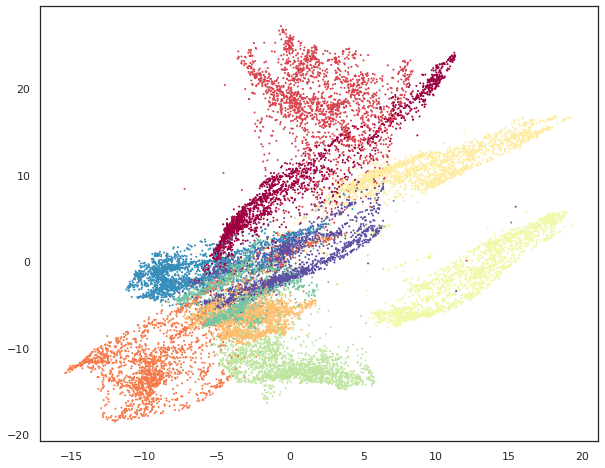

In [ ]:
plt.scatter(trimap_embedding[:,2], trimap_embedding[:, 6], c=y_train, s=1, cmap='Spectral');

In [ ]:
labels = hdbscan.HDBSCAN(min_samples=25, min_cluster_size=750).fit_predict(trimap_embedding)


In [ ]:
adjusted_rand_score(y_train, labels), adjusted_mutual_info_score(y_train, labels)

(0.6663493888978917, 0.7909613798620592)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
gs = trimap.TRIMAP(verbose=False).global_score(x_train, trimap_embedding)
print("global score %2.2f" % gs)

global score 0.56


In [12]:
from sklearn.preprocessing import StandardScaler
embedding = StandardScaler().fit_transform(embedding)

In [13]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=13, n_iter=4000)
clusterable_embedding = model.fit_transform(embedding)

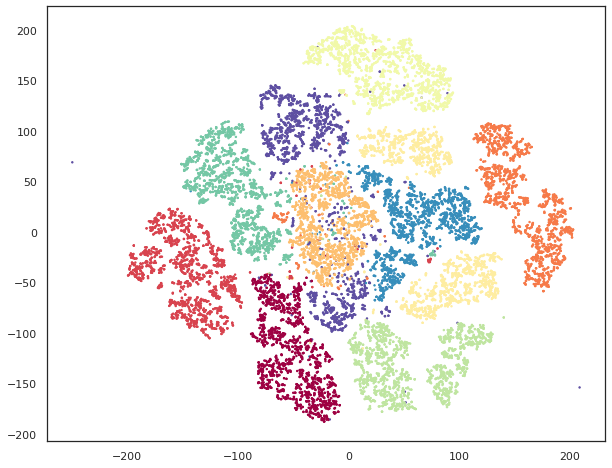

In [16]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=2, cmap='Spectral');

In [17]:
labels = hdbscan.HDBSCAN(min_samples=30, min_cluster_size=30).fit_predict(clusterable_embedding)

In [19]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

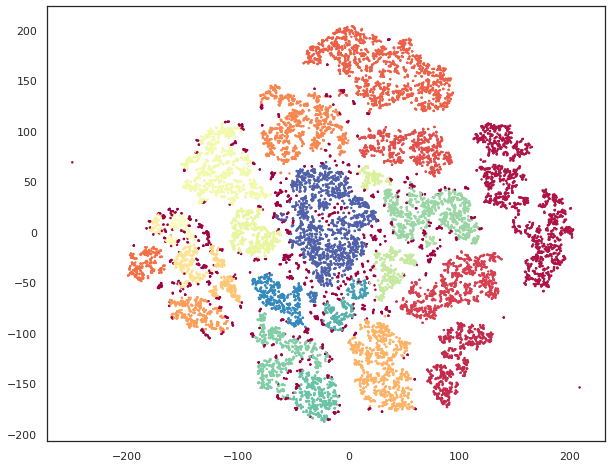

In [18]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=labels, s=2, cmap='Spectral');

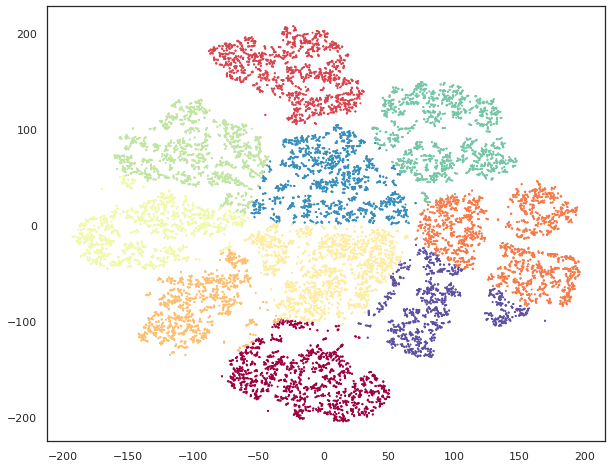

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(clusterable_embedding)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=kmeans_labels, s=1, cmap='Spectral');

In [ ]:
(
    adjusted_rand_score(y_train, kmeans_labels),
    adjusted_mutual_info_score(y_train, kmeans_labels)
)


(0.6657079370234467, 0.7483482543881145)

In [ ]:
#lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=250, min_cluster_size=250).fit_predict(clusterable_embedding)

In [ ]:
adjusted_rand_score(y_train, hdbscan_labels), adjusted_mutual_info_score(y_train, hdbscan_labels)

(0.2254889455504088, 0.5954132493584974)

In [ ]:
np.unique(hdbscan_labels)

NameError: ignored

In [ ]:
adjusted_rand_score(y_train, labels), adjusted_mutual_info_score(y_train, labels)

(0.21200935429338155, 0.5842231863963504)

In [ ]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=2, cmap='Spectral');

NameError: ignored

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


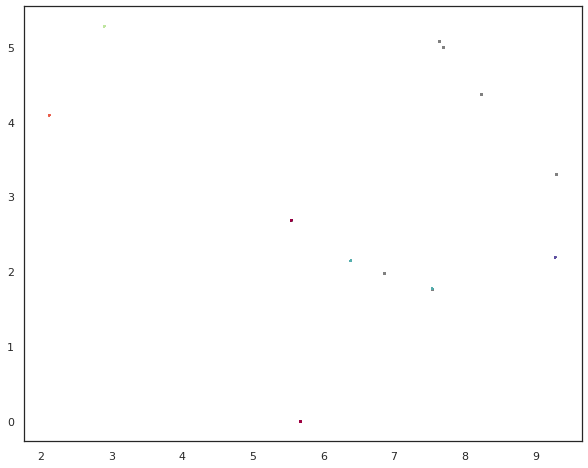

In [ ]:
#clustered = (hdbscan_labels >= 0)
clustered = hdbscan_labels

plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');


In [ ]:
(
    adjusted_rand_score(y_test_lite, hdbscan_labels),
    adjusted_mutual_info_score(y_test_lite, hdbscan_labels)
)


(0.2591518669518714, 0.37484683956050685)

In [ ]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(y_test_lite[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(y_test_lite[clustered], hdbscan_labels[clustered])
)

(0.29199684939428466, 0.4225847000273803)

In [ ]:
np.sum(clustered) / x_test_lite.shape[0]

0.871

In [50]:
umap_embedding = umap.UMAP(
    n_neighbors=50,
    min_dist=0,
    n_components=2,
    random_state=42,
).fit_transform(embedding)


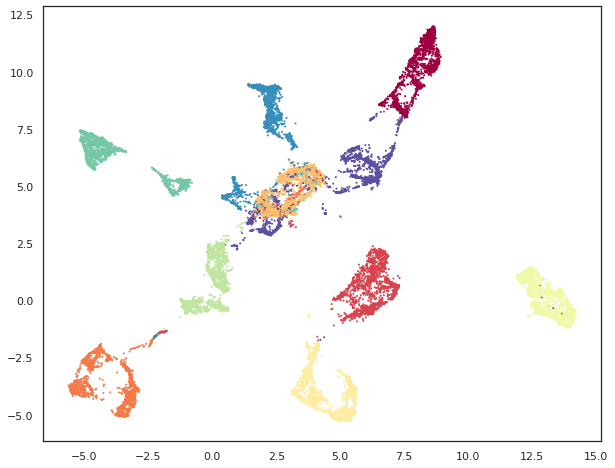

In [52]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],
            c=y_train, s=1, cmap='Spectral');


In [40]:
labels = hdbscan.HDBSCAN(
    min_samples=300,
    min_cluster_size=150,
).fit_predict(clusterable_embedding)

In [41]:
adjusted_rand_score(y_train, labels), adjusted_mutual_info_score(y_train, labels)

(0.1947029029491995, 0.5069725766858093)

In [42]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
clustered = (labels >= 0)
(
    adjusted_rand_score(y_test[clustered], labels[clustered]),
    adjusted_mutual_info_score(y_test[clustered], labels[clustered])
)


(-0.0007650249248378022, -0.0035302888660917833)

In [ ]:
np.sum(clustered) / x_test.shape[0]

0.8226923076923077